### Kütüphaneler

In [1]:
import torch
import torch.nn as nn 
import torch.optim as optim
from PIL import Image
import torchvision.transforms as transforms 
import torchvision
import os
import pandas as pd
from torch.utils.data import (Dataset,DataLoader) 
from skimage import io
import time

import warnings
warnings.filterwarnings("ignore")

### Veriyi Dahil Etme

In [5]:
class veri(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = io.imread(img_path)
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))
        
        if self.transform:
            image = self.transform(image)
            
        return (image, y_label)

### Veriyi Hazırlama

In [12]:
dataset = veri(csv_file = r"f113.csv",
              root_dir = r"f1_classification",
              transform = transforms.Compose([
                  transforms.ToTensor(),
                  #transforms.ToPILImage(mode=None),
                  #transforms.Resize(size = (28, 28)),
                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

### Veri Ön İşleme

In [13]:
train_set,  test_set = torch.utils.data.random_split(dataset, [200,79]) 
train_loader = DataLoader(dataset=train_set, batch_size=1, shuffle=False)
test_loader = DataLoader(dataset=test_set, batch_size=1, shuffle=False)

### Veriyi Görselleştirme

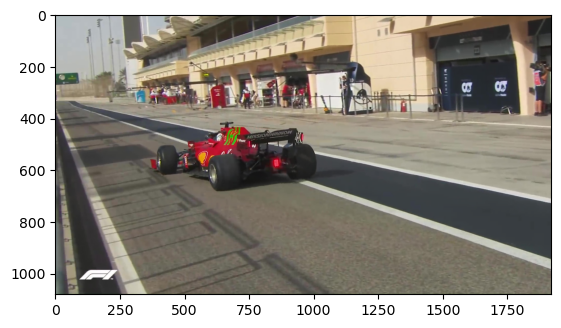

Ferrari
torch.Size([1, 3, 1080, 1920])


In [14]:
import matplotlib.pyplot as plt
import numpy as np
batch_size = 1
classes = ["Ferrari", "Mclaren", "Mercedes", "Redbull"]

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2,0)))
    plt.show()
    
    
dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

print(" ".join("%5s" % classes[labels[j]] for j in range(batch_size)))
print(images.size())

In [23]:
start = time.time()
print("Transfer Learning Eğitimi Başlıyor")
print("-------------------------------------------")

import torchvision.models as models

model = models.densenet161(pretrained=True)

for param in model.parameters():
    param.requires_grad = False
    
model.classifier = nn.Sequential(

nn.Linear(2208,1000),
nn.ReLU(inplace = True),
nn.Linear(1000,100),
nn.ReLU(inplace = True),
nn.Linear(100,50),
nn.ReLU(inplace = True),
nn.Linear(50,4)

)

error = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epoch = 1
count = 0
iterasyon = []

for i in range(epoch):
    for i, (images, label) in enumerate(train_loader):
        
        out = model(images)
        loss = error(out, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        count+=1
        
        if count % 20 == 0:
            iterasyon.append(count)
            print("İterasyon: {} -- loss:{:.4f}".format(count, loss.item()))





print("Transfer Learning Eğitimi Bitti")
print("-------------------------------------------")
end = time.time()
print("süre: ", end-start)

Transfer Learning Eğitimi Başlıyor
-------------------------------------------
İterasyon: 20 -- loss:1.5191
İterasyon: 40 -- loss:1.2236
İterasyon: 60 -- loss:1.3838
İterasyon: 80 -- loss:1.3066
İterasyon: 100 -- loss:1.3468
İterasyon: 120 -- loss:1.3379
İterasyon: 140 -- loss:1.0517
İterasyon: 160 -- loss:1.2197
İterasyon: 180 -- loss:1.5234
İterasyon: 200 -- loss:1.3390
Transfer Learning Eğitimi Bitti
-------------------------------------------
süre:  2185.774126291275


In [20]:
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

### Model Testi

In [31]:
def dogruluk(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    #device=toch.device("cuda")
    #model = model.to(device)
    with torch.no_grad():
        for x, y in loader:
            #x = x.to(device)
            #y = y.to(device)
            
            out = model(x.float())
            _, pred = out.max(1)
            num_correct += (pred == y)
            num_samples += pred.size(0)
            
        print(
            f"Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)* 100 : .2f}"
        )
            
        model.train()

In [32]:
print("Train Doğruluk:")
dogruluk(train_loader, model)
print("Test Doğruluk:")
dogruluk(test_loader, model)

Train Doğruluk:
Got tensor([52]) / 200 with accuracy  26.00
Test Doğruluk:
Got tensor([26]) / 79 with accuracy  32.91
